### **RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval**

[RAPTOR](https://arxiv.org/pdf/2401.18059.pdf) 논문은 문서의 색인 생성 및 검색에 대한 흥미로운 접근 방식을 제시

[테디노트 논문 요약글(노션)](https://teddylee777.notion.site/RAPTOR-e835d306fc664dc2ad76191dee1cd859?pvs=4)

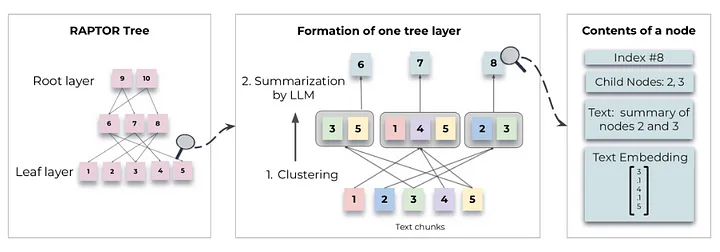

1. Text Chunk => Clustering
2. Summarization by LLM

In [ ]:
# !pip install -U umap-learn

### **Data Processing**

23


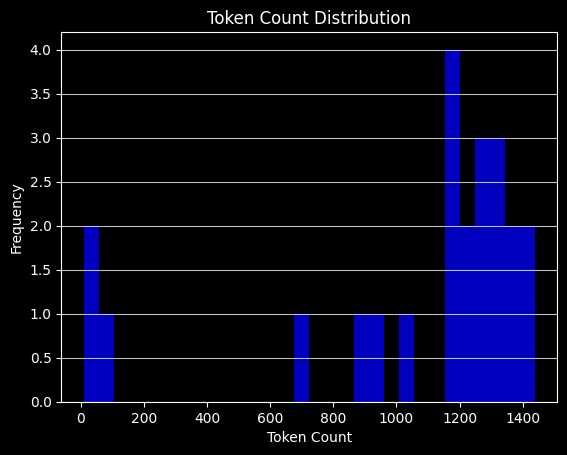

In [2]:
from langchain_community.document_loaders import PDFPlumberLoader
import tiktoken
import matplotlib.pyplot as plt

# 토큰 수 계산
def num_tokens_from_string(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Load the PDF
loader = PDFPlumberLoader('data/SPRI_AI_Brief_2023년12월호_F.pdf')
docs = loader.load()
print(len(docs))

# 텍스트 추출
docs_texts = [i.page_content for i in docs]

# 각 문서의 토큰 수 계산
count = []
for d in docs_texts:
    count.append(num_tokens_from_string(d, 'cl100k_base'))
    
# 토큰 수 히스토그램
plt.hist(count, bins=30, alpha=0.75, color='b')
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [3]:
# 문서 텍스트 정렬(MetaData의 Source를 기준으로) 후 모든 문서 연결 

# 문서 텍스트 정렬
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 역순으로 배열된 문서의 내용 연결 
concatenated_content = '\n\n\n --- \n\n\n'.join([doc.page_content for doc in d_reversed])

print(f"문서 전체 토큰 : {num_tokens_from_string(concatenated_content, 'cl100k_base')}개")

문서 전체 토큰 : 24131개


In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 텍스트 분할기
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 100, chunk_overlap = 0) 

# 텍스트 분할
texts_split = text_splitter.split_text(concatenated_content)

In [5]:
# Local Store에 저장 
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

# Cache 저장 경로
store = LocalFileStore('./cache/')

# 임베딩 모델 정의
embeddings = OpenAIEmbeddings(model = "text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings 정의
cache_embeddings = CacheBackedEmbeddings.from_bytes_store(embeddings, store, namespace = embeddings.model)

In [6]:
# 모델 설정 
from langchain_openai import ChatOpenAI

# llm 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### **트리구축**

**GMM (가우시안 혼합 모델)**

- 다양한 클러스터에 걸쳐 데이터 포인트의 분포를 모델링
- 모델의 베이지안 정보 기준(BIC)을 평가하여 최적의 클러스터 수를 결정

**UMAP (Uniform Manifold Approximation and Projection)**

- 클러스터링
- 고차원 데이터의 차원을 축소
- UMAP은 데이터 포인트의 유사성에 기반하여 자연스러운 그룹화를 강조

**지역 및 전역 클러스터링**

- 데이터를 저차원으로 차원 축소하여 클러스터링을 수행

**임계값 설정**

- GMM의 맥락에서 클러스터 멤버십을 결정하기 위해 적용
- 확률 분포를 기반(데이터 포인트를 ≥ 1 클러스터에 할당).

### 차원 축소

`global_cluster_embeddings`

- 입력된 임베딩 벡터를 전역적으로 차원 축소하기 위해 UMAP을 적용합니다. 전역적으로 차원을 축소한 결과물을 얻어 추후 클러스터링에 활용합니다.

**과정**

- n_neighbors: UMAP에 사용될 이웃(neighbor) 수를 정합니다. 데이터 포인트 하나를 이해할 때 주변 데이터 포인트 개수를 나타냅니다. 입력이 없으면 데이터 개수에 따라 자동으로 계산합니다.
- umap.UMAP(...)를 사용하여, 고차원 임베딩을 dim 차원으로 축소합니다.
- 축소된 벡터들은 전역적(global)인 구조 파악에 도움이 되는 저차원 표현입니다.

---

`local_cluster_embeddings`

- 선택한 데이터 부분집합에 대해 로컬(국소적) 차원 축소를 수행합니다.

**과정**

- 글로벌 차원 축소와 유사하지만, 로컬 차원 축소는 이미 한 번 전역 클러스터링을 통해 추출한 특정 그룹(글로벌 클러스터) 내 데이터에 대해 다시 UMAP을 적용합니다.
- 이 과정은 전역적으로 파악된 큰 구조 안에서 더 세밀한 클러스터 구조를 파악하는 데 도움이 됩니다.